# Interaction models data convergence
How fast do models converge? With interaction terms, a more complex model should take longer to converge.
Can we show this by training against different data lengths.

Can we get the best of both worlds by converging the main effects fast, and then introduce complexity when needed?

Start by importing stuff:

In [1]:
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-whitegrid")


/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_11015/563970410.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


Let's generate some data.
We will generate some linear data and include interaction terms.

Data is generated as follows:

In [8]:
import numpy as np
import sklearn.preprocessing

RND = np.random.default_rng(0)

def gen_data(
    n: int = 100_000,
    x_dim: int = 6,
    noise_level: float = 2.0,
    interaction_scale:float =0.01
):

    # base features
    x_base = pd.DataFrame(RND.uniform(-1, 1, size=(n, x_dim)))

    # add interactions
    int_trans = sklearn.preprocessing.PolynomialFeatures(
        interaction_only=True, degree=2, include_bias=False
    ).set_output(transform="pandas")
    x = int_trans.fit_transform(x_base)

    # make weights
    bias = RND.uniform(-1, 1, size=(1))
    w = RND.uniform(-1, 1, size=(x.shape[1]))
    # scale interaction weights
    w[x_dim:] = interaction_scale * w[x_dim:]

    # make outcomes
    z = np.dot(x, w)
    y = bias + z + noise_level * RND.normal(size=(n))

    return x, y, w, bias, z

n = 100_000
x_dim = 6
x, y, w, bias, z = gen_data(n=n, x_dim=x_dim)

## Train models

Split train/test

In [3]:
x_train = x[: n // 2]
x_test = x[n // 2 :]
y_train = y[: n // 2]
y_test = y[n // 2 :]


### Linear models

In [32]:
import sklearn.linear_model


def predict_model(x_train: np.array, y_train: np.array, x_test: np.array) -> np.array:
    ...


def predict_model_pair_int(
    x_train: np.array, y_train: np.array, x_test: np.array
) -> np.array:
    _model = sklearn.linear_model.LinearRegression()
    _model.fit(x_train, y_train)
    return _model.predict(x_test)


def predict_model_base(
    x_train: np.array, y_train: np.array, x_test: np.array
) -> np.array:
    _model = sklearn.linear_model.LinearRegression()
    _model.fit(x_train[:, :x_dim], y_train)
    return _model.predict(x_test[:, :x_dim])


def train_models(
    models: dict[str, callable],
    x_train: np.array,
    y_train: np.array,
    x_test: np.array,
) -> dict:
    y_est = {}
    for _name in models.keys():
        y_est[_name] = {}

    for _data_filt in [100, 500, 1_000, 10_000]:
        for _name, _model in models.items():
            y_est[_name][_data_filt] = _model(
                x_train[1:_data_filt], y_train[1:_data_filt], x_test
            )
    return y_est


y_est = train_models(
    models={"base": predict_model_base, "pair_int": predict_model_pair_int},
    x_train=x_train.to_numpy(),
    y_train=y_train,
    x_test=x_test.to_numpy(),
)


Evaluate

In [33]:
import sklearn.metrics

def get_metrics(y_est, y_test)->pl.DataFrame:
    metrics = {}
    for _name, _model_est in y_est.items():
        metrics[_name] = {}
        for _data_filt, _y_est in _model_est.items():
            metrics[_name][_data_filt] = sklearn.metrics.mean_squared_error(y_test, _y_est)
    
    metrics = pl.DataFrame(
        pd.DataFrame(metrics).reset_index().rename(columns={"index": "data_size"})
    )
    return metrics

metrics = get_metrics(y_est=y_est, y_test=y_test)
metrics


data_size,base,pair_int
i64,f64,f64
100,4.44022,5.420123
500,4.01134,4.145325
1000,3.971839,4.055699
10000,3.962687,3.967246


/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_11015/2772836682.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


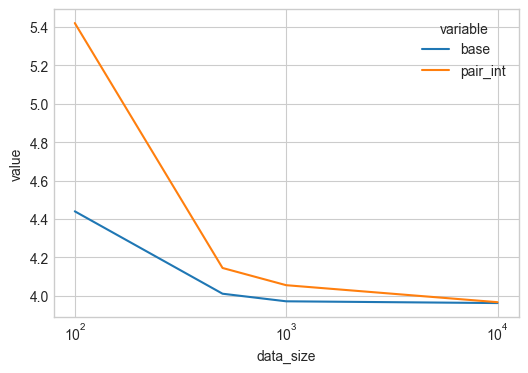

In [34]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(
    data=metrics.melt(id_vars="data_size"),
    x="data_size",
    y="value",
    hue="variable",
    ax=ax,
)
ax.set_xscale("log")
fig.show()


## Bootstrap

100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_11015/3015194584.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


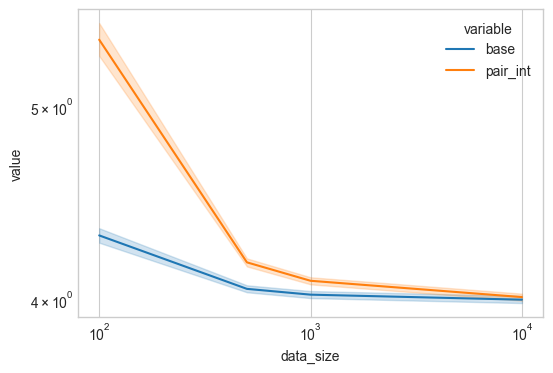

In [37]:
import tqdm


def train_loop(n: int = 100_000, x_dim: int = 6, interaction_scale: float = 0.01):
    x, y, w, bias, z = gen_data(n=n, x_dim=x_dim, interaction_scale=interaction_scale)

    x_train = x[: n // 2]
    x_test = x[n // 2 :]
    y_train = y[: n // 2]
    y_test = y[n // 2 :]

    y_est = train_models(
        models={"base": predict_model_base, "pair_int": predict_model_pair_int},
        x_train=x_train.to_numpy(),
        y_train=y_train,
        x_test=x_test.to_numpy(),
    )
    _metrics = get_metrics(y_est=y_est, y_test=y_test)
    return _metrics


metrics = []
for _i in tqdm.trange(100):
    metrics.append(train_loop(n = 10_000, x_dim = 6, interaction_scale = 0.01))
metrics = pl.concat(metrics)

fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(
    data=metrics.melt(id_vars="data_size"),
    x="data_size",
    y="value",
    hue="variable",
    ax=ax,
)
ax.set_xscale("log")
ax.set_yscale("log")
fig.show()


High interaction effects

Interactions model asymptotically outperforms. But it still under performs at the beginning.

100%|██████████| 100/100 [00:28<00:00,  3.46it/s]
/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_11015/4116153191.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


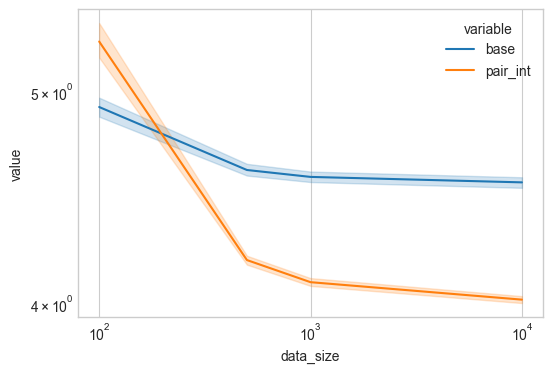

In [38]:

metrics = []
for _i in tqdm.trange(100):
    metrics.append(train_loop(n = 10_000, x_dim = 6, interaction_scale = 1.0))
metrics = pl.concat(metrics)

fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(
    data=metrics.melt(id_vars="data_size"),
    x="data_size",
    y="value",
    hue="variable",
    ax=ax,
)
ax.set_xscale("log")
ax.set_yscale("log")
fig.show()


100%|██████████| 100/100 [00:24<00:00,  4.02it/s]
/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_11015/2019398205.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


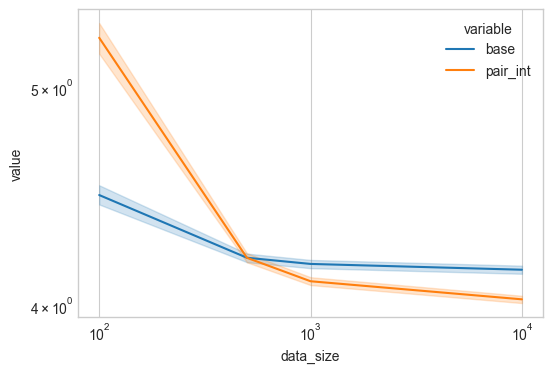

In [39]:

metrics = []
for _i in tqdm.trange(100):
    metrics.append(train_loop(n = 10_000, x_dim = 6, interaction_scale = 0.5))
metrics = pl.concat(metrics)

fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(
    data=metrics.melt(id_vars="data_size"),
    x="data_size",
    y="value",
    hue="variable",
    ax=ax,
)
ax.set_xscale("log")
ax.set_yscale("log")
fig.show()


# TODO

* Partial fit the models to speed up training
* Test each iteration

Check partial fit is equal to full fit

In [43]:
import sklearn.linear_model

model = sklearn.linear_model.SGDRegressor(penalty=None,)
model.partial_fit(X=x_train, y=y_train)
model.coef_

array([ 0.71869589,  0.43086063,  0.82965746, -0.42977068,  0.25626562,
        0.34086657,  0.04828486,  0.00660319,  0.07131285,  0.02953855,
       -0.01516764, -0.04829925, -0.01497959, -0.01817903,  0.02268757,
       -0.010188  , -0.02089637, -0.00840172, -0.00201246, -0.01668222,
        0.01860047])

In [42]:

model = sklearn.linear_model.LinearRegression()
model.fit(X=x_train, y=y_train)
model.coef_

array([ 0.68883933,  0.47942596,  0.82683236, -0.39308809,  0.28586444,
        0.37568671,  0.01259534, -0.00765286,  0.03515664,  0.03171415,
       -0.00336891, -0.04733151, -0.00313704, -0.02078241,  0.00398647,
        0.0008517 ,  0.00616672, -0.02261724,  0.02247865,  0.00312883,
        0.01228236])